In [34]:
import warnings
warnings.filterwarnings("ignore")

In [51]:
!conda install pandas -y

Solving environment: done

## Package Plan ##

  environment location: /Applications/anaconda3/envs/adversarial-defenses

  added / updated specs:
    - pandas


The following NEW packages will be INSTALLED:

  pandas             pkgs/main/osx-64::pandas-1.2.4-py37h23ab428_0
  pytz               pkgs/main/noarch::pytz-2021.1-pyhd3eb1b0_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [52]:
from tensorflow.contrib.slim.nets import inception
import tensorflow as tf
import matlab.engine
from config import Config
from cleverhans.attacks import FastGradientMethod
import numpy as np
import os
import pandas as pd
from scipy.misc import imread
from scipy.misc import imsave
from io import BytesIO
from PIL import Image
import IPython.display
from utils.sample_attacks.fgsm.attack_fgsm import save_images

In [3]:
def load_images(input_dir, batch_shape):
    images = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in sorted(tf.gfile.Glob(os.path.join(input_dir, '*.png'))):
        with tf.gfile.Open(filepath, "rb") as f:
            images[idx, :, :, :] = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
        filenames.append(os.path.basename(filepath))
        idx += 1
        if idx == batch_size:
            yield filenames, images
            filenames = []
            images = np.zeros(batch_shape)
            idx = 0
    if idx > 0:
        yield filenames, images

def show_image(a, fmt='png'):
    a = np.uint8((a+1.0)/2.0*255.0)
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [4]:
class InceptionModel(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.built = False

    def __call__(self, x_input):
        """Constructs model and return probabilities for given input."""
        reuse = True if self.built else None
        with slim.arg_scope(inception.inception_v3_arg_scope()):
            _, end_points = inception.inception_v3(
                            x_input, num_classes=self.num_classes, is_training=False,
                            reuse=reuse)
        self.built = True
        output = end_points['Predictions']
        probs = output.op.inputs[0]
        return probs

In [192]:
slim = tf.contrib.slim 
# categories = pd.read_csv("../project_miscellaneous/nips-2017-defense-against-adversarial-attack/dev_toolkit/dataset/dev_dataset.csv")
categories = pd.read_csv("../project_miscellaneous/nips-2017-adversarial-learning-development-set/inputs/categories.csv")
image_width          = 299
image_height         = 299
checkpoint_path      = "./inception_v3.ckpt"
input_dir            = './demo/original'
output_dir           = './demo/adversarial'
tensorflow_master   = ''
max_epsilon          = 16.0
image_width          = 299
image_height         = 299
batch_size           = 1

In [11]:
# eps = 2.0 * max_epsilon / 255.0
batch_shape = [batch_size, image_height, image_width, 3]
num_classes = 1001

tf.logging.set_verbosity(tf.logging.ERROR) # so we don't get a bunch of logging info

In [196]:
all_eps = np.append(np.linspace(0, 0.2, 21), 1)
all_eps = list(map(lambda x: round(x, 2), all_eps))
adv_images = dict()
for eps in all_eps:
    with tf.Graph().as_default():
        # Prepare graph
        x_input = tf.placeholder(tf.float32, shape=batch_shape)

        model = InceptionModel(num_classes)

        fgsm = FastGradientMethod(model)
        x_adv = fgsm.generate(x_input, eps=eps, clip_min=-1., clip_max=1.)

        # Run computation
        saver = tf.train.Saver(slim.get_model_variables())
        session_creator = tf.train.ChiefSessionCreator(
                                scaffold=tf.train.Scaffold(saver=saver),
                                checkpoint_filename_with_path=checkpoint_path)

        with tf.train.MonitoredSession(session_creator=session_creator) as sess:
            filenames, images = next(load_images(input_dir, batch_shape))
            adv_images[eps] = sess.run(x_adv, feed_dict={x_input: images})[0]

In [197]:
predicted_nontargeted_classes = dict()
predicted_nontargeted_classes_names = dict()
with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(x_input, num_classes=num_classes, is_training=False)
    
    predicted_labels = tf.argmax(end_points['Predictions'], 1)
    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        for eps in all_eps:
            predicted_classes = sess.run(predicted_labels, feed_dict={x_input: images})
    #         predicted_nontargeted_classes = sess.run(predicted_labels, feed_dict={x_input: nontargeted_images})
            predicted_nontargeted_classes[eps] = sess.run(predicted_labels, feed_dict={x_input: [adv_images[eps]]})

            predicted_nontargeted_classes_names[eps] = (pd.DataFrame({"CategoryId": predicted_nontargeted_classes[eps]})
                                      .merge(categories, on="CategoryId")["CategoryName"].tolist())

# No Defense

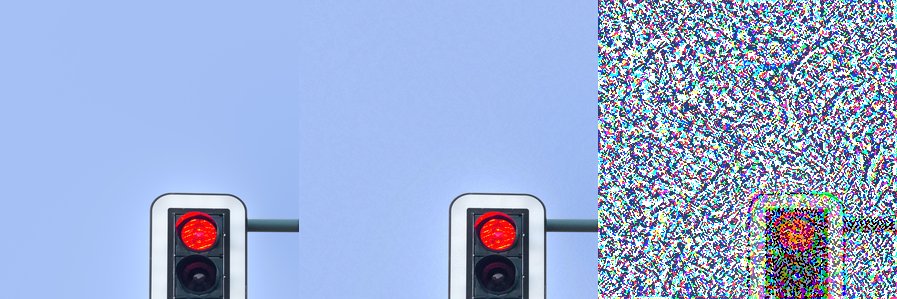

In [204]:
show_image(np.concatenate([adv_images[0], adv_images[0.01], adv_images[1]], axis=1))

In [203]:
print(predicted_classes_names)
print(predicted_nontargeted_classes_names[0.01])
print(predicted_nontargeted_classes_names[1])

['traffic light, traffic signal, stoplight']
['iPod']
['chainlink fence']


# Random Noise

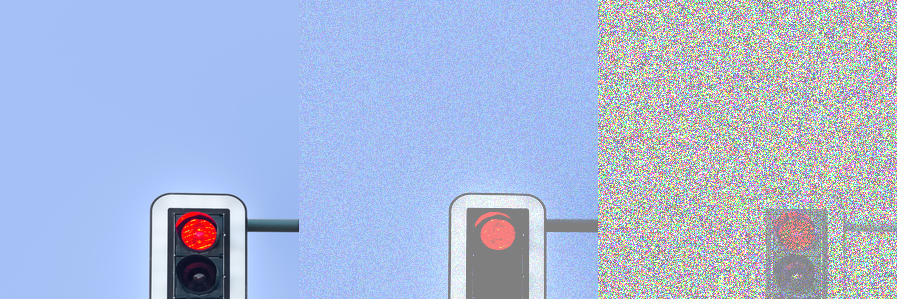

In [200]:
show_image(np.concatenate([adv_images[0], out_images[0.1], out_images[1]], axis=1))

In [148]:
print(predicted_classes_names)
print(predicted_noise_classes_names_0p1)
print(predicted_noise_classes_names_1)


['traffic light, traffic signal, stoplight']
['traffic light, traffic signal, stoplight']
['switch, electric switch, electrical switch']


# JPEG

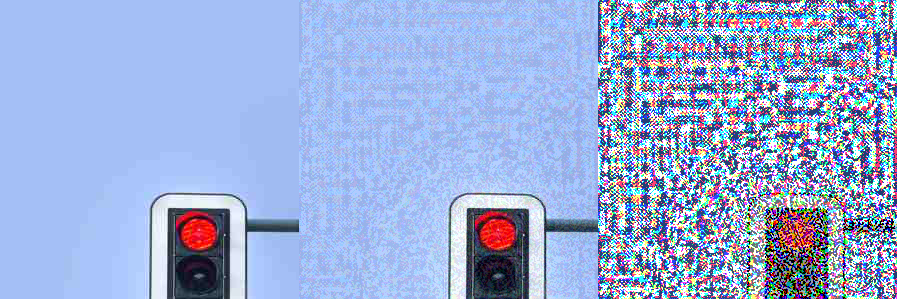

In [190]:
show_image(np.concatenate([adv_images_jpeg[0], adv_images_jpeg[0.1], adv_images_jpeg[1]], axis=1))

In [205]:
print(predicted_classes_names)
print(predicted_nontargeted_classes_names_jpeg[0.01])
print(predicted_nontargeted_classes_names_jpeg[1])

['traffic light, traffic signal, stoplight']
['cellular telephone, cellular phone, cellphone, cell, mobile phone']
['apron']


# PCA

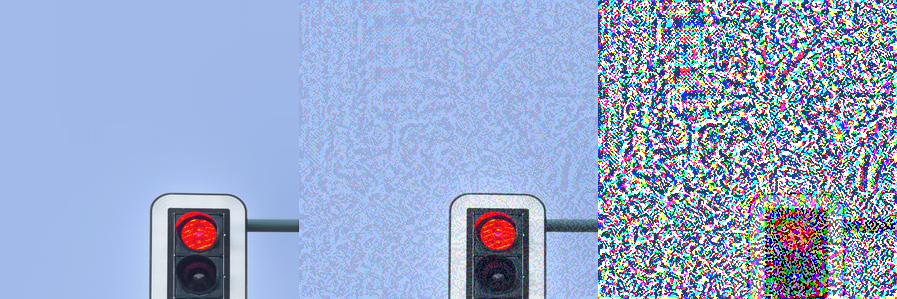

In [179]:
show_image(np.concatenate([adv_images_pca[0], adv_images_pca[0.1], adv_images_pca[1]], axis=1))

In [206]:
print(predicted_classes_names)
print(predicted_nontargeted_classes_names_pca[0.01])
print(predicted_nontargeted_classes_names_pca[1])

['traffic light, traffic signal, stoplight']
['iPod']
['bubble']


In [119]:
all_eps = np.linspace(0, 1, 11)
out_images = dict()
for eps in all_eps:
    with tf.Graph().as_default():
        x_input = tf.placeholder(tf.float32, shape=batch_shape)
        noisy_images = x_input + eps * tf.sign(tf.random_normal(batch_shape))
        x_output = tf.clip_by_value(noisy_images, 0.0, 1.0)

        with tf.Session(master) as sess:
            filenames, images = next(load_images(input_dir, batch_shape))
            out_images[round(eps, 2)] = sess.run(x_output, feed_dict={x_input: images})[0]

In [126]:
with tf.Graph().as_default():
    x_input = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(x_input, num_classes=num_classes, is_training=False)
    
    predicted_labels = tf.argmax(end_points['Predictions'], 1)
    saver = tf.train.Saver(slim.get_model_variables())
    session_creator = tf.train.ChiefSessionCreator(
                      scaffold=tf.train.Scaffold(saver=saver),
                      checkpoint_filename_with_path=checkpoint_path,
                      master=tensorflow_master)

    with tf.train.MonitoredSession(session_creator=session_creator) as sess:
        predicted_classes = sess.run(predicted_labels, feed_dict={x_input: images})
#         predicted_nontargeted_classes = sess.run(predicted_labels, feed_dict={x_input: nontargeted_images})
        predicted_nontargeted_classes_0p1 = sess.run(predicted_labels, feed_dict={x_input: [out_images[0.1]]})
        predicted_nontargeted_classes_1 = sess.run(predicted_labels, feed_dict={x_input: [out_images[1]]})
        
predicted_classes_names = (pd.DataFrame({"CategoryId": predicted_classes})
                           .merge(categories, on="CategoryId")["CategoryName"].tolist())

# predicted_nontargeted_classes_names = (pd.DataFrame({"CategoryId": predicted_nontargeted_classes})
#                           .merge(categories, on="CategoryId")["CategoryName"].tolist())

predicted_noise_classes_names_0p1 = (pd.DataFrame({"CategoryId": predicted_nontargeted_classes_0p1})
                          .merge(categories, on="CategoryId")["CategoryName"].tolist())
predicted_noise_classes_names_1 = (pd.DataFrame({"CategoryId": predicted_nontargeted_classes_1})
                          .merge(categories, on="CategoryId")["CategoryName"].tolist())

In [61]:
cd "adversarial-examples"

/Users/aaronkelley/Documents/Academic/School/UNAM/Semestre2/Redes/ProyectoFinal/adversarial-examples


In [87]:
adv_images.keys()

dict_keys([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

['traffic light, traffic signal, stoplight']
['traffic light, traffic signal, stoplight']
['switch, electric switch, electrical switch']


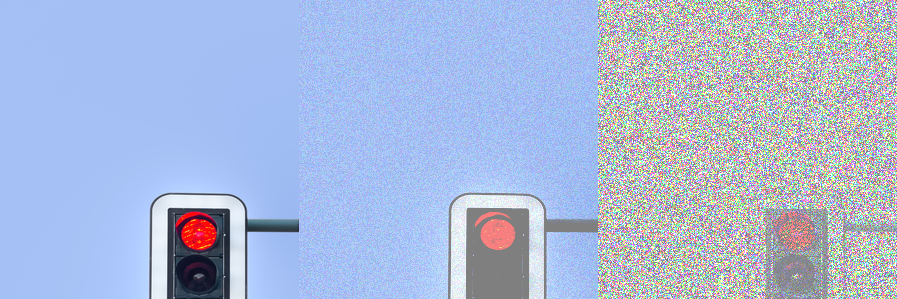

TypeError: Cannot handle this data type: (1, 1, 299, 3), |u1

In [23]:
for eps in all_eps:
    with tf.Graph().as_default():
        # Prepare graph
        x_input = tf.placeholder(tf.float32, shape=batch_shape)

        model = InceptionModel(num_classes)

        fgsm = FastGradientMethod(model)
        x_adv = fgsm.generate(x_input, eps=eps, clip_min=-1., clip_max=1.)

        # Run computation
        saver = tf.train.Saver(slim.get_model_variables())
        session_creator = tf.train.ChiefSessionCreator(
                                scaffold=tf.train.Scaffold(saver=saver),
                                checkpoint_filename_with_path=checkpoint_path)

    #     with tf.Session() as sess:
    #         sess.run(tf.global_variables_initializer())
    #         saver = tf.train.Saver(slim.get_model_variables())
    #         saver.restore(sess, checkpoint_path)
    #         for filenames, images in load_images(input_dir, batch_shape):
    #             adv_images = sess.run(x_adv, feed_dict={x_input: images})
    #             save_images(adv_images, filenames, output_dir)


        with tf.train.MonitoredSession(session_creator=session_creator) as sess:
            for filenames, images in load_images(input_dir, batch_shape):
                adv_images = sess.run(x_adv, feed_dict={x_input: images})
                new_fnames = []
                for f in filenames:
                    new_fnames.append(os.path.splitext(f)[0]+'_'+str(round(eps, 2)).replace('.', 'p')+'.png')
                save_images(adv_images, new_fnames, output_dir)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/Applications/anaconda3/envs/adversarial-defenses/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


In [ ]:
conf = Config();
tf.logging.set_verbosity(tf.logging.INFO)

In [ ]:
image_width       = 299
image_height      = 299
checkpoint_path   = "../../inception_v3.ckpt"
input_dir         = './images'
tensorflow_master = ""

slim = tf.contrib.slim
batch_shape = conf.batch_shape
num_classes = 1001

In [ ]:
max_epsilon       = 16.0
eps               = 2.0 * max_epsilon / 255.0

In [ ]:
conf.subset_num = 16

In [ ]:
dataset_path     = "dataset/"
attack_base_dir  = dataset_path + "attack/"
denoise_base_dir = dataset_path + "DenoisedSamples/"
benign_dir        = dataset_path + "attack/benign"

defense_name = "jpeg_75"
attack_save_dir = "dataset/attack"
denoised_benign_dir = dataset_path + "/DenoisedSamples/"+defense_name+"/benign"


random_seed = conf.random_seed
subset_num  = conf.subset_num
image_list = get_image_list(benign_dir, random_seed, subset_num)
image_list = ['0c7ac4a8c9dfa802.png']
img_fmt = 'jpg'

In [ ]:
image_list

In [ ]:
image_iterator = load_images_helper(input_dir, batch_shape)
filenames, images = next(image_iterator)

In [ ]:
images = load_images_helper(image_list, benign_dir, denoised_benign_dir, batch_shape, img_fmt)

In [ ]:
for eps in np.linspace(0.01, 0.1, num=10):
    adv_args = {'eps': eps, 'clip_min':-1., 'clip_max':1., 'nb_iter':1}
    with tf.Graph().as_default():
                with tf.Session() as sess:
                    x_benign = tf.placeholder(tf.float32, shape=batch_shape)
                    x_denoised = tf.placeholder(tf.float32, shape=batch_shape)
                    model = InceptionModel(num_classes)
                    adv_method  = FastGradientMethod(model, sess=sess)
                    x_adv = adv_method.generate(x_benign, **adv_args)

                    predicted_labels, nb_classes = adv_method.get_or_guess_labels(x_benign, {})
                    predicted_labels = tf.argmax(predicted_labels, 1)
                    print(nb_classes)

                    sess.run(tf.global_variables_initializer())
                    saver = tf.train.Saver(slim.get_model_variables())
                    saver.restore(sess, checkpoint_path)
                    save_dir_path = attack_save_dir+'/'+defense_name+'/'+str(eps)+'/'
                    os.mkdir(save_dir_path)
                    print('entering loop')
                    for filenames, denoised_images, images in load_images_helper(image_list, benign_dir, denoised_benign_dir, batch_shape, img_fmt):
                        print(len(filenames))
                        print(np.linalg.norm(denoised_images[0] - images[0]))
                        nontargeted_images = sess.run(x_adv, feed_dict={x_denoised: denoised_images, x_benign : images})
                        save_images(nontargeted_images, filenames, save_dir_path)

In [ ]:
dataset_path     = "dataset/"
attack_base_dir  = dataset_path + "attack/"
denoise_base_dir = dataset_path + "DenoisedSamples/"
benign_dir        = dataset_path + "/benign"

defense_name = "pca_whole_5"
attack_save_dir = "dataset/attack"
denoised_benign_dir = dataset_path + "DenoisedSamples/"+defense_name+"/benign"

In [ ]:
image_list = ['0c7ac4a8c9dfa802.png']
batch_shape = [1, 299, 299, 3]
slim = tf.contrib.slim
num_classes = 906

In [ ]:
imgdir_path = benign_dir
imgdir_denoised = denoised_benign_dir
batch_shape = conf.batch_shape 
img_fmt = 'png'

In [ ]:
load_images_helper(
    image_list, 
    benign_dir, 
    denoised_benign_dir, 
    conf.batch_shape,
    'png')

In [ ]:
filepath = image_list[0]

In [ ]:

# benign unprotected
f = tf.gfile.Open(os.path.join(imgdir_path, filepath), "rb")
im_og = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
# benign protected (denoised)
g = tf.gfile.Open(os.path.join(imgdir_denoised, filepath), "rb")
im_dn = imread(g, mode='RGB').astype(np.float)*2.0/255.0 - 1.0



In [ ]:
nb_classes

In [ ]:
tf.argmax(predicted_labels, 1)

In [ ]:
adv_args = {'eps': 0.1, 'clip_min':-1., 'clip_max':1., 'nb_iter':1}
graph = tf.Graph()
with graph.as_default():
    with tf.Session(graph=graph) as sess:
        x_benign = tf.placeholder(tf.float32, shape=batch_shape)
        x_denoised = tf.placeholder(tf.float32, shape=batch_shape)
        
        model = InceptionModel(num_classes) # init model
        fgsm  = FastGradientMethod(model, sess=sess) # attack method
        x_adv = fgsm.generate(x_benign, **adv_args)

        predicted_labels, nb_classes = fgsm.get_or_guess_labels(x_benign, {})
        predicted_labels = tf.argmax(predicted_labels, 1)
        
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver(slim.get_model_variables())
        saver.restore(sess, checkpoint_path)

In [ ]:
def load_images_helper(image_list, imgdir_path, imgdir_denoised, batch_shape, img_fmt):
    images = np.zeros(batch_shape)
    images_denoised = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in image_list:
        with tf.gfile.Open(os.path.join(imgdir_path, filepath), "rb") as f:
            images[idx, :, :, :] = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
        if img_fmt == 'jpg':
            filepath = filepath.replace('png', img_fmt)
        with tf.gfile.Open(os.path.join(imgdir_denoised, filepath), "rb") as f:
            images_denoised[idx, :, :, :] = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
        if img_fmt == 'jpg':
            filepath = filepath.replace(img_fmt, 'png')
        filenames.append(os.path.basename(filepath))
        idx += 1
        if idx == batch_size:
            yield filenames, images_denoised, images
            filenames = []
            images = np.zeros(batch_shape)
            images_denoised = np.zeros(batch_shape)
            idx = 0
    if idx > 0:
        yield filenames, images_denoised, images

In [ ]:
def get_image_list(benign_dir, random_seed, subset_num):
    images_whole      = [f for f in os.listdir(benign_dir) if os.path.isfile(os.path.join(benign_dir, f))]
    images_whole      = sorted(images_whole)

    if random_seed != None:
        random.seed(random_seed)
        # generate random indices to subset
        subset_ids  = random.sample(range(len(images_whole)), subset_num)  
    else:
        subset_ids  = range(subset_num)

    image_list = [images_whole[i] for i in subset_ids]
    return image_list

In [ ]:
def save_images(images, filenames, output_dir):
    for i, filename in enumerate(filenames):
        img = np.uint8(((images[i, :, :, :] + 1.0) * 0.5) * 255.0)
        imsave(output_dir+filename, img)

In [11]:
def load_images(input_dir, batch_shape):
    images = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in sorted(tf.gfile.Glob(os.path.join(input_dir, '*.png'))):
        with tf.gfile.Open(filepath, "rb") as f:
            images[idx, :, :, :] = imread(f, mode='RGB').astype(np.float)*2.0/255.0 - 1.0
        filenames.append(os.path.basename(filepath))
        idx += 1
        if idx == batch_size:
            yield filenames, images
            filenames = []
            images = np.zeros(batch_shape)
            idx = 0
    if idx > 0:
        yield filenames, images

def show_image(a, fmt='png'):
    a = np.uint8((a+1.0)/2.0*255.0)
    f = BytesIO()
    Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
